In [1]:
%pip install -U torchvision
import torch
from tqdm.auto import tqdm, trange
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
import numpy as np

     |████████████████████████████████| 21.0 MB 2.9 MB/s 
     |████████████████████████████████| 750.6 MB 12 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.11.0 which is incompatible.


In [33]:
class tanh_discr(torch.autograd.Function):
    '''
    Implementation of discretized 𝑡𝑎𝑛ℎ activation functions.
    Returns value from -1 to +1
    In backward pass behaves as ordinary tanh

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Parameters:
        - n - discretization parameter

    References:
        - See related paper:
        https://arxiv.org/pdf/2105.01768.pdf

    Examples:
        >>> x = torch.randn(256)
        >>> x = tanh_discr.apply(x, 256)
    '''
    @staticmethod
    def forward(ctx, x, n=2):
        '''
        Forward pass of the function.
        Applies the function to the input elementwise.
        '''
        th = torch.tanh(x)
        ctx.save_for_backward(th)
        _n = (n-1)/2
        return torch.round(_n + _n * th) / _n - 1
    
    @staticmethod
    def backward(ctx, grad_output):
        th, = ctx.saved_tensors
        return (1 - th ** 2) * grad_output, None

class PreEncoder(nn.Module):
    def __init__(self, num_layers=6, num_channels=128, kernel_size=5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(3, num_channels, kernel_size, padding='same')])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size, padding='same'))

    def forward(self, x):
        for conv in self.convs:
            x = torch.relu(conv(x))
        return x

class DownDiscretizationEncoder(nn.Module):
    def __init__(self, kernel_size=5, input_channels = 128):
        super().__init__()
        num_layers=8
        self.convs = nn.ModuleList([nn.Conv2d(input_channels, 1, kernel_size, padding='same')])
        for i in range(num_layers - 1):
            self.convs.append(nn.Conv2d(1, 1, kernel_size, padding='same'))
        
    def forward(self, x):
        for removed_bits, conv in enumerate(self.convs):
            x = tanh_discr.apply(conv(x), 2 ** (8 - removed_bits))
        return x

class Decoder(nn.Module):
    def __init__(self, num_layers=2, num_channels=128, kernel_size=5):
        super().__init__()
        self.convs = nn.ModuleList([nn.Conv2d(1, num_channels, kernel_size, padding='same')])
        for i in range(num_layers - 2):
            self.convs.append(nn.Conv2d(num_channels, num_channels, kernel_size, padding='same'))
        self.convs.append(nn.Conv2d(num_channels, 3, kernel_size, padding='same'))

    def forward(self, x):
        for conv in self.convs[:-1]:
            x = F.relu(conv(x))
        x = torch.tanh(self.convs[-1](x))
        return x

class TexturesModel(nn.Module):
    def __init__(self, num_layers=6, num_channels=128, kernel_size=5, alpha=0.1, beta=0.1):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.pre_encoder = PreEncoder(num_layers, num_channels, kernel_size=kernel_size)
        self.dde = DownDiscretizationEncoder(input_channels=num_channels, kernel_size=kernel_size)
        self.decoder = Decoder(num_layers, num_channels, kernel_size=kernel_size)
        self.tau = 1

    def sample_gumbel(shape, eps=1e-20):
      u = torch.rand(*shape).to('cuda')
      return (-torch.log(-torch.log(u + eps)))

    def sample_gumbel_softmax(self, logits, temperature):
      g = self.sample_gumbel(logits.shape)
      h = (g + logits)/temperature
      h_max = h.max(dim=-1, keepdim=True)[0]
      h = h - h_max
      cache = torch.exp(h)
      y = cache / cache.sum(dim=-1, keepdim=True)
      return y

    def forward(self, x):
        x = self.pre_encoder(x)
        x = self.dde(x)
        x = F.log_softmax(x.view(-1,128), dim=-1)
        x = self.sample_gumbel_softmax(x, self.tau)
        return x

    def encode_decode(self, x):
        x = self.pre_encoder(x)
        x = self.dde(x)
        x = F.log_softmax(x.view(-1,128), dim=-1)
        x = self.sample_gumbel_softmax(x, self.tau)
        x = self.decoder(x)
        return x

    def compute_loss(self, x):
        stride = 8
        encoded = self.dde(self.pre_encoder(x))
        decoded = self.decoder(encoded)
        restoration_loss = F.mse_loss(x, decoded)
        input_brightness = F.avg_pool2d(x.mean(axis=1, keepdims=True), 8, stride=stride).ravel()
        input_brightness_diffs = input_brightness - input_brightness.T
        encoded_brghtness = F.avg_pool2d(encoded, 8, stride=stride).ravel()
        encoded_brghtness_diffs = encoded_brghtness - encoded_brghtness.T
        intensicy_loss = (torch.tanh(input_brightness_diffs)- torch.tanh(encoded_brghtness_diffs) ).abs().mean()
        color_shift = transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        color_continuity_loss = (encoded- self.dde(self.pre_encoder(color_shift(x)))).abs().mean()

        total_loss = restoration_loss + self.alpha * intensicy_loss + self.beta * color_continuity_loss
        return total_loss



In [41]:
import torchvision.transforms as transforms
batch_size = 16
device = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

stl_data = torchvision.datasets.STL10(root='/stl_data', transform=transform, split='unlabeled', download=True)
stl_loader = torch.utils.data.DataLoader(stl_data, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

# celeba_data = torchvision.datasets.CelebA(root='/celeba_data', split='train', transform=transform, download=True)
# celeba_loader = torch.utils.data.DataLoader(celeba_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# cars_data = torchvision.datasets.StanfordCars(root='/cars_data', transform=transform, download=True)
# cars_loader = torch.utils.data.DataLoader(cars_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())

# imagenet_data = torchvision.datasets.ImageNet('./imagenet_data', download=True, transform=transforms.ToTensor(), split='val')
# imagenet_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=torch.cuda.is_available())


Files already downloaded and verified


In [35]:
import torch.optim as optim

net = TexturesModel().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0001)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/196 [00:00<?, ?it/s]

[1] loss: 0.009012298658490181


  0%|          | 0/196 [00:00<?, ?it/s]

[2] loss: 0.008501882664859295


  0%|          | 0/196 [00:00<?, ?it/s]

[3] loss: 0.006136199925094843


  0%|          | 0/196 [00:00<?, ?it/s]

[4] loss: 0.00442919647321105
Finished Training


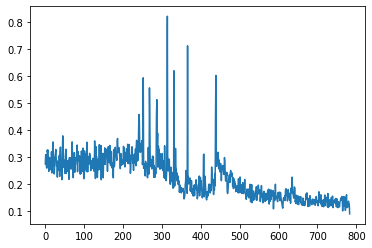

In [42]:
loader = stl_data
evens = list(range(0, len(loader), 32))
loader = torch.utils.data.Subset(loader, evens)

loader = torch.utils.data.DataLoader(loader, batch_size=batch_size,
                                            shuffle=False, num_workers=2,pin_memory=torch.cuda.is_available())
running_loss = 0.0
losses = []
for epoch in trange(4):  # loop over the dataset multiple times
    
    for data in tqdm(loader, leave=False, total=len(loader)):
        # get the inputs; data is a list of [inputs, labels]
        inputs, _ = data
        inputs = inputs.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        loss = net.compute_loss(inputs) 
        loss.backward()
        optimizer.step()

        running_loss += loss
        losses.append(loss.cpu().detach())
    # print statistics
    tqdm.write(f'[{epoch + 1}] loss: {running_loss/len(stl_loader)}')
    running_loss = 0.0

plt.plot(losses)

print('Finished Training')